Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Xiong Qiao"
COLLABORATORS = ""

---

# Homework 4: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: 11/1/18, 11:59PM
## Course Policies

Here are some important course policies. These are also located at
http://www.ds100.org/fa18/.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

## This Assignment
In this homework, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this homework, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimize overfitting
- Generating and analyzing precision recall curves

## Warning
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

## Regarding Submissions - IMPORTANT, PLEASE READ


For this assignment and future assignments (homework and projects) you will also submit your free response and plotting questions to Gradescope. To do this, you can download as PDF; there are two ways to do this:

 

1. File > Print Preview ----> Save website as PDF
2. Control/Command + P ----> Save website as PDF
 

If you are having trouble with text being cut off in the generated PDF:

- For cells containing text surrounded in triple quotes (e.g. """ Hello world """), you can press enter in the middle of the string to push the text to a new line so that all the text stays within the box.


You are responsible for submitting and tagging your answers in Gradescope. For each free response and plotting question, please include:

1. Relevant code used to generate the plot or inform your insights
2. The written free response or plot

# Part I - Initial Analysis

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam). 

Your labeled dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email
1. `email`: The text of the email.
1. `spam`: 1 if the email was spam, 0 if the email was ham (not spam).

The `test` DataFrame contains another set of 1000 unlabeled examples. You will predict labels for these examples and submit your predictions to Kaggle for evaluation.

In [3]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Fri Oct 26 17:25:57 2018
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Fri Oct 26 17:25:56 2018
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


# Question 1a
First let's check if our data contains any nan values. *Fill in the cell below to print whether any of the columns contain nan values.* If there are nan values, replace them with the appropriate filler values. In other words, a nan value in the subject column should be replaced with an empty string. 

Note that while there are no nan values in the spam column, we should be careful when replacing nan values when they are the labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [4]:
# YOUR CODE HERE
print('columns that contain nan values in test data:')
for col in test.columns:
    if test[col].isnull().value_counts().index.contains(True):
        print(col)

print('columns that contain nan values in training data:')
for col in original_training_data.columns:
    if original_training_data[col].isnull().value_counts().index.contains(True):
        print(col)

test['subject'].fillna('', inplace=True)
original_training_data['subject'].fillna('', inplace=True)

columns that contain nan values in test data:
subject
columns that contain nan values in training data:
subject


# Question 1b
In the cell below, print the text of the first ham and the first spam email in the original training set. Then, discuss one thing you notice that is different between the two that might relate to the identification of spam.

In [5]:
# Print the text of the first ham and the first spam emails. Then, fill in your response in the q01 variable:
first_ham = original_training_data[original_training_data['spam'] == 0].iloc[0, 2]
first_spam = original_training_data[original_training_data['spam'] == 1].iloc[0, 2]

# YOUR CODE HERE
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [6]:
# This is a cell with just a comment but don't delete me if you want to get credit.

The spam email contains lots of html tags, while the ham email just contains plain words that totally makes sense to hunman beings.  

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to validate your model once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers. Do not modify this in the following questions, as our assert statements depend on this random seed.

In [7]:
from sklearn.model_selection import train_test_split

[train, val] = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the text is ham or spam. This is a *classification* problem, so we can use logistic regression to make a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $\Phi$ (pronounced phi as in wifi) and corresponding binary labels $Y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\Phi$ is derived from one email example. Each column of $\Phi$  is one feature. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

# Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```python
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello world hello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [8]:
words = ['hello', 'bye', 'world']
texts = pd.Series(['hello', "<br>would you rather have<br>more than enough to get the job done or fall = \
 short. it's totally up<br>to you."])
resut1 = np.array(texts.str.contains('hello', regex=False)) *1
resut2 = np.array(texts.str.contains('bye', regex=False))*1
np.stack((resut1, resut2), axis=-1)

array([[1, 0],
       [0, 0]])

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_word = [texts.str.contains(word, regex=False) * 1 for word in words] 
    indicator_array = np.stack(indicator_word, axis=-1)
    
    # YOUR CODE HERE
    return indicator_array

In [10]:
# If this doesn't error, your function outputs the correct output for this example
assert np.allclose(words_in_texts(['hello', 'bye', 'world'], 
                                  pd.Series(['hello', 'hello world hello'])),
                   np.array([[1, 0, 0], 
                             [1, 0, 1]]))

assert np.allclose(words_in_texts(['a', 'b', 'c', 'd', 'e', 'f', 'g'], 
                                  pd.Series(['a b c d e f g', 'a', 'b', 'c', 'd e f g', 'h', 'a h'])),
                   np.array([[1,1,1,1,1,1,1], 
                             [1,0,0,0,0,0,0],
                             [0,1,0,0,0,0,0],
                             [0,0,1,0,0,0,0],
                             [0,0,0,1,1,1,1],
                             [0,0,0,0,0,0,0],
                             [1,0,0,0,0,0,0]]))

# Basic EDA

Now we need to identify some features that allow us to tell spam and ham emails apart. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


# Question 3a

Create a bar chart comparing the proportion of spam and ham emails containing certain words. It should look like the following plot (which was created using `sns.barplot`), but you should choose your own words as candidate features. Make sure to use the training set (after splitting).

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for example

In [11]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df)
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,type,word_1,word_2
0,spam,1,0
1,ham,0,1
2,ham,1,0
3,ham,0,1


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


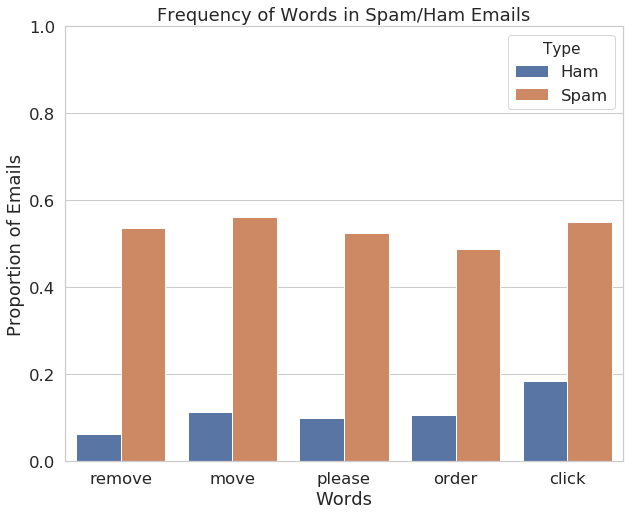

In [12]:
train=train.reset_index() # We must do this in order to preserve the ordering of emails to labels for words_in_texts

# words = ['body', 'business', 'html', 'money', 'offer', 'please']
# words = ['drug', 'bank', 'prescription', 'memo', 'private']
words = ['remove', 'move', 'please', 'order', 'click']
words_indicate = pd.DataFrame(data=words_in_texts(words, train['email']), columns=words)
# YOUR CODE HERE
words_count = pd.merge(train, words_indicate, left_index=True, right_index=True)
# words_count.drop(columns=['id', 'level_0', 'index', 'subject', 'email'], inplace=True)
words_count.drop(columns=['id', 'index', 'subject', 'email'], inplace=True)
words_count.melt('spam')
temp = words_count.groupby('spam').sum()

# words_count_prop = temp.loc[0:1, :] / words_count['spam'].value_counts()[0]
# temp.loc[1:2, :] / words_count['spam'].value_counts()[1]

words_count_prop = pd.concat([temp.loc[0:0, :] / words_count['spam'].value_counts()[0], 
                            temp.loc[1:1, :] / words_count['spam'].value_counts()[1]])

words_count_prop = words_count_prop.reset_index().melt('spam')
words_count_prop.rename(columns={'variable':'word', 'value':'prop', 'spam': 'Type'}, inplace=True)
words_count_prop.replace({'Type':{0:'Ham', 1:'Spam'}}, inplace=True)
# words_count_prop.rename(index=str, columns={'spam': 'Type'}, inplace=True)

# Draw graph
plt.figure(figsize=(10, 8))

sns.barplot(x='word', y='prop', hue='Type', data=words_count_prop)
plt.title('Frequency of Words in Spam/Ham Emails')
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.ylim((0, 1))
plt.show()

# Question 3b

When the feature is binary, it makes sense (as in the previous question) to compare the proportion of 1s in the two classes of email. Otherwise, if the feature can take on many values, it makes sense to compare the distribution under spam to the distribution under ham. Create a *class conditional density plot* like the one below (which was created using `sns.distplot`), comparing the distribution of a feature among all spam emails to the distribution of the same feature among all ham emails. You should use your training set (after splitting). **You may use the length of the email body or create your own feature.** If using length of the email body, please set the xlim to 50000.

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")

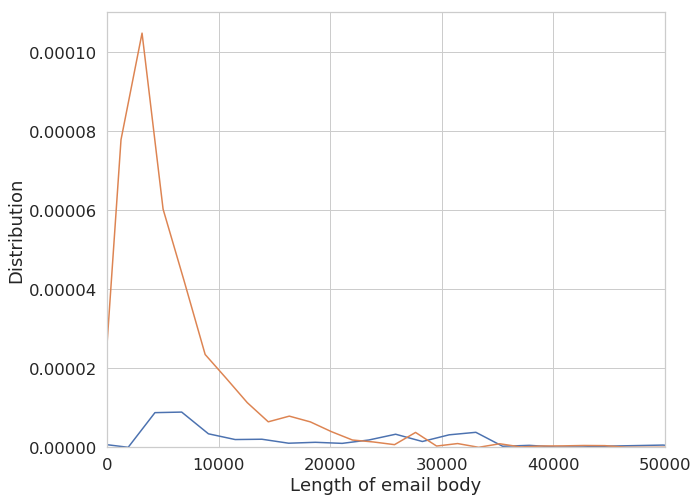

In [13]:
# YOUR CODE HERE
length_ham = train[train['spam'] == 0]['email'].str.len()
length_spam = train[train['spam'] == 1]['email'].str.len()

plt.figure(figsize=(10, 8))

sns.distplot(length_ham, hist=False)
sns.distplot(length_spam, hist=False)
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.xlim((0, 50000))
plt.show()

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

# Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `Phi_train` and `Y_train`.

`Phi_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

In [14]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

Phi_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

# YOUR CODE HERE
# raise NotImplementedError()

Phi_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [15]:
print(len(Phi_train))

7513


In [16]:
assert np.all(np.unique(Phi_train) == np.array([0, 1]))
assert np.all(np.unique(Y_train) == np.array([0, 1]))
assert Phi_train.shape[0] == Y_train.shape[0]
assert Phi_train.shape[1] == len(some_words)

# Question 5

Now we have matrices we can give to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `Phi_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy of around 0.75.

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(Phi_train, Y_train)

Y_pred = model.predict(Phi_train)
training_accuracy = sum(Y_pred == Y_train) / len(Phi_train)
print(training_accuracy)
# YOUR CODE HERE


0.7576201251164648


In [18]:
assert training_accuracy > 0.72

# Question 6

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are validating on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. Since we are trying  There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham. Answer the following questions in the cells below:

- (a) Suppose we have a classifier that just predicts 0 (ham) for every email. How many false positives are there? How many false negatives are there? Provide specific numbers using the training data from Question 4.
- (b) Suppose we have a classifier that just predicts 0 (ham) for every email. What is its accuracy on the training set? What is its recall on the training set?
- (c) What are the precision, recall, and false-alarm rate of the logistic regression classifier in Question 5? Are there more false positives or false negatives? 
- (d) Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
- (e) Given the word features we gave you above, name one reason this classifier is performing poorly.
- (f) Which of these two classifiers would you prefer for a spam filter and why? (N.B. there is no "right answer" here but be thoughtful in your reasoning).

In [19]:
# provide number of FP and FN, respectively,
# for a classifier that always predicts 0 (never predicts positive...)
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train)

# YOUR CODE HERE
print(zero_predictor_fn)

1918


In [20]:
# This is a cell with just a comment but don't delete me if you want to get credit.

In [21]:
# provide training accuracy & recall, respectively,
# for a classifier that always predicts 0
zero_predictor_acc = np.sum(Y_train == 0) / len(Y_train)
zero_predictor_recall = 0

# YOUR CODE HERE
print('acc is %s' % zero_predictor_acc)

acc is 0.744709170771


In [22]:
# This is a cell with just a comment but don't delete me if you want to get credit.

In [23]:
# provide training accuracy & recall, respectively,
# for logistic regression classifier from question 5
logistic_predictor_precision = np.sum(np.logical_and(Y_pred, Y_train)) / np.sum(Y_pred)
logistic_predictor_recall = np.sum(np.logical_and(Y_pred, Y_train)) / np.sum(Y_train)
logistic_predictor_far = np.sum(np.logical_and(Y_train==0, Y_pred==1)) / np.sum(Y_train == 0)

# YOUR CODE HERE
print('precision is %s, recall is %s, far is %s' % (logistic_predictor_precision, 
                                          logistic_predictor_recall, logistic_predictor_far))
FP = np.sum(np.logical_and(Y_train==0, Y_pred==1))
FN = np.sum(np.logical_and(Y_train==1, Y_pred==0))
if (FP > FN):
    print('There are more false positives')
elif (FP == FN):
    print('There are equal amount false positives and false negatives')
else:
    print('There are more false negatives')

precision is 0.642228739003, recall is 0.114181438999, far is 0.0218051831993
There are more false negatives


In [24]:
# This is a cell with just a comment but don't delete me if you want to get credit.

(a) #fp = 0, #fn = 1918

(b) acc = 0.744709170771, recall = 0

(c) precision = 0.642228739003, recall = 0.114181438999, far = 0.0218051831993
There are more false negatives

(d) The accuracy of our logistic regression is a little higher than that of predicting 0 for every email(75.6% vs 74.5%).

(e) When I draw a plot showing the frequency of these 5 words in spam/ham emails, I found their proportions are really low and some of them don't have an obvious difference between two kinds of emails. Hence, I think these bad
feature choices result in our classifier performing poorly.

(f) I prefer predicting the model of predicting 0 for every email and I have 2 reasons. First, the accuracy of 
this model is nealy the same as logistic regression. Sencond and more importantly, false positive is 0 for this 
model which means it will never mislabel a ham email as spam so that I'll never miss the important meaningful emails.

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

To prevent you from overfitting to the test set, you may only upload predictions to Kaggle twice per day. This means you should start early and rely on your **validation data** to estimate your Kaggle scores.  

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features. However, **you are only allowed to train logistic regression models and their regularized forms**. This means no random forest, k-nearest-neighbors, neural nets, etc.

We will not give you a code skeleton to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [25]:
train.count()

index      7513
id         7513
subject    7513
email      7513
spam       7513
dtype: int64

In [26]:
# Use the top 100-150 words that have the biggest difference between spam and ham emails as word features.
# First, find the top 500 words that appear most in the training emails.
tidy_format = (train.loc[1:100, 'email'].str.replace(r'<[^>]*>', '')
                         .str.replace(r'[^a-zA-Z]', ' ')
)

tidy_format = (tidy_format.str.split(expand=True)
                .stack().reset_index(level=1)
              )

tidy_format.rename({'level_1': 'num', 0: 'word'}, inplace=True, axis='columns')

# We only want words whose length are greater than 3
tidy_format = tidy_format[tidy_format['word'].str.len() >= 3]

In [27]:
test_df = pd.DataFrame(data = {'num': [0, 1, 2, 3, 4], 'word': ['url', 'http', 'diveintomark', 'org', 'archives']})
test_df.groupby('word').count()

,num
word,
archives,1
diveintomark,1
http,1
org,1
url,1


In [28]:
word_count_pd = tidy_format.groupby('word').count().sort_values('num', ascending=False).iloc[0:500]
words = word_count_pd.index.tolist()

In [29]:
train=train.reset_index() # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words_indicate = pd.DataFrame(data=words_in_texts(words, train['email']), columns=words)

words_count = pd.merge(train, words_indicate, left_index=True, right_index=True)
words_count.drop(columns=['id', 'level_0', 'index', 'subject_x', 'email_x'], inplace=True)
words_count.melt('spam_x')
temp = words_count.groupby('spam_x').sum()

words_count_prop = temp.loc[0:1, :] / words_count['spam_x'].value_counts()[0]
temp.loc[1:2, :] / words_count['spam_x'].value_counts()[1]

words_count_prop = pd.concat([temp.loc[0:0, :] / words_count['spam_x'].value_counts()[0], 
                            temp.loc[1:1, :] / words_count['spam_x'].value_counts()[1]])


In [30]:
prop_diff = abs(words_count_prop.iloc[0] - words_count_prop.iloc[1])
word_features = prop_diff.sort_values(ascending=False)[0:150].index.tolist()

In [31]:
# Set up features using the words chose above
Phi_train = words_in_texts(word_features, train['email'])
Y_train = train['spam']

Phi_val = words_in_texts(word_features, val['email'])
Y_val = val['spam']
# YOUR CODE HERE

# Phi_train[:5], Y_train[:5]

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(Phi_train, Y_train)

Y_pred = model.predict(Phi_train)
training_accuracy = sum(Y_pred == Y_train) / len(Phi_train)

Y_pred = model.predict(Phi_val)
val_accuracy = sum(Y_pred == Y_val) / len(Phi_val)
print(training_accuracy, val_accuracy)

0.9739118860641555 0.9688622754491018


In [33]:
# # Use the length of the title as another feature
# train['subject_len'] = train['subject'].str.len()

# Phi_train = train['subject_len'].values.reshape(-1, 1)
# Phi_val = val['subject'].str.len().values.reshape(-1, 1)

# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression().fit(Phi_train, Y_train)

# Y_pred = model.predict(Phi_train)
# training_accuracy = sum(Y_pred == Y_train) / len(Phi_train)

# Y_pred = model.predict(Phi_val)
# val_accuracy = sum(Y_pred == Y_val) / len(Phi_val)
# print(training_accuracy, val_accuracy)

# Question 7 (Feature/Model Selection Process)

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

1. I first cleaned the email by elimnating puncations and html tags. Then I found the top 500 words that appear most commonly in the training emails. Next, I calculated the frequency of each of these 500 words in spam and ham emails respectively. Finally, I chose the top 150 words that have the biggest frequency difference between spam and ham emails to do a logistic regression.

2. I tried to use top 150 words that have the biggest frequency differences as my word features and it worked pretty well which got a 97.33% accuracy on training data. I also tried to use the length of the title as my feature only to find it didn't work. It only had a acc of 74.47%, nearly the same as just predict all emails as hams.

3. Firstly, I thought only using better word features may not be enough for a very good model but after I tried the top 150 words that have the biggest frequency differences the model turned out to be quite good althought some words 

# Question 8 (EDA)

In the two cells below, show a visualization that you used to select features for your model. Include both

1. A plot showing something meaningful about the data that helped you during feature / model selection.
2. 2-3 sentences describing what you plotted and what its implications are for your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the cells below.

**You should not show us a visualization just like in question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Use a word-cloud or another visualization tool to characterize the most common spam words.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

In [34]:
# Actually, I used 150 word featues but it would be too messy if I include them all in the plot so I only used 
# the top50
word_features_to_show = prop_diff.sort_values(ascending=False)

# plt.figure(figsize=(10, 8))
# word_features[0: 50].plot.bar()
# plt.show()

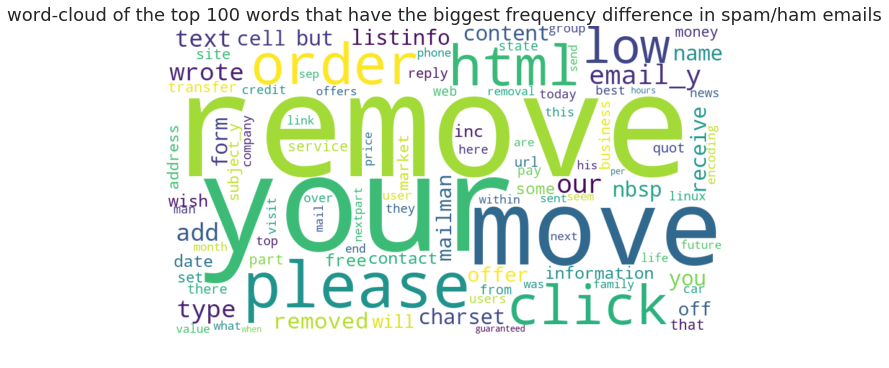

In [35]:
# YOUR CODE HERE

# !pip install wordcloud
from wordcloud import WordCloud


wordcloud = WordCloud(width=900, height=500, max_words=100, relative_scaling=1, background_color='white',
                      normalize_plurals=False).generate_from_frequencies(word_features_to_show)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('word-cloud of the top 100 words that have the biggest frequency difference in spam/ham emails')
plt.axis("off")
plt.show()

From the above word-cloud, we can see some words have really big frequency differences in spam/ham emails, like **your**, **remove**, **move**, **please** etc. Hence, they could potentially be really good featues to distinguish between 
spam and ham emails.

# Question 9 (Making a Precision-Recall Curve)

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The precision-recall curve shows this trade off for each possible cutoff probability. In the cell below, [plot a precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) for your final classifier (the one you use to make predictions for Kaggle).

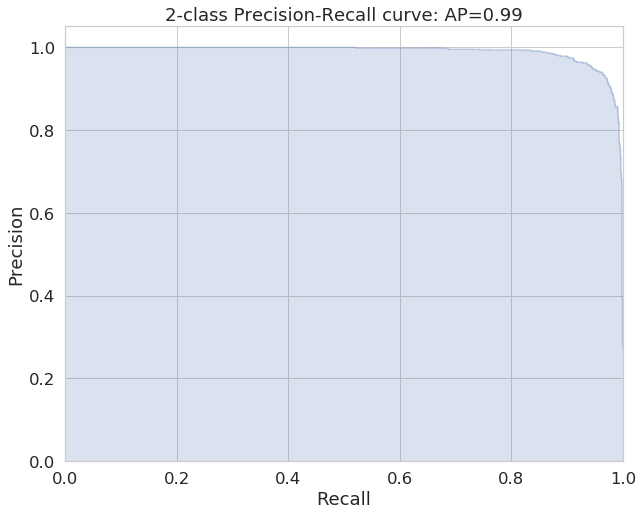

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

# YOUR CODE HERE
y_score = model.predict_proba(Phi_train)[:, 1]

precision, recall, _ = precision_recall_curve(Y_train, y_score)
average_precision = average_precision_score(Y_train, y_score)
step_kwargs = ({'step': 'post'}
              if 'step' in signature(plt.fill_between).parameters
              else {})

plt.figure(figsize=(10, 8))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()

# Question 10: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your grade for this part will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/t/d9a7013e7fd048c291ff7efe6e1ac25e

In [37]:
test.head()

,id,subject,email
0,0,Subject: CERT Advisory CA-2002-21 Vulnerabilit...,\n \n -----begin pgp signed message-----\n \n ...
1,1,Subject: ADV: Affordable Life Insurance ddbfk\n,low-cost term-life insurance!\n save up to 70%...
2,2,Subject: CAREER OPPORTUNITY. WORK FROM HOME\n,------=_nextpart_000_00a0_03e30a1a.b1804b54\n ...
3,3,Subject: Marriage makes both sexes happy\n,"url: http://www.newsisfree.com/click/-3,848315..."
4,4,Subject: Re: [SAtalk] SA very slow (hangs?) on...,on thursday 29 august 2002 16:39 cet mike burg...


In [38]:
# CHANGE ME (Currently making random predictions)
Phi_test = words_in_texts(word_features, test['email'])
test_predictions = model.predict(Phi_test)

# YOUR CODE HERE


In [39]:
# must be ndarray of predictions
assert isinstance(test_predictions, np.ndarray) 

# must be binary labels (0 or 1) and not probabilities
assert np.all((test_predictions == 0) | (test_predictions == 1))

# must be the right number of predictions
assert test_predictions.shape == (1000, )

In [40]:
# Please do not modify this cell

The following saves a file to submit to Kaggle.

In [41]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# must be ndarray of predictions
assert isinstance(test_predictions, np.ndarray) 

# must be binary labels (0 or 1) and not probabilities
assert np.all((test_predictions == 0) | (test_predictions == 1))

# must be the right number of predictions
assert test_predictions.shape == (1000, )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2018-11-09T06:37:13.csv.
You may now upload this CSV file to Kaggle for scoring.


## Submission

You're done!

Before submitting this assignment, ensure to:

1. Restart the Kernel (in the menubar, select Kernel->Restart & Run All)
2. Validate the notebook by clicking the "Validate" button

Finally, make sure to **submit** the assignment via the Assignments tab in Datahub